### Четвертое домашнее задание. Эксперименты.

In [56]:
import torch
from tqdm import tqdm 
from torch.distributions.multivariate_normal import MultivariateNormal

class BayesianPCA:
    def __init__(self, n_components, m_size, n_size):
        self.d_size = n_components
        self.m_size = m_size
        self.n_size = n_size
    def E_step_(self):
        self.C = torch.linalg.inv(1/self.sigma * self.W.T @ self.W + torch.eye(self.d_size))
        self.m = [1/self.sigma * self.C @ self.W.T @(xi - self.mu) for xi in self.X]
    def M_step_(self):
        ### Calculate W*
        a = torch.zeros((self.n_size, self.d_size))
        b = torch.zeros((self.d_size, self.d_size))
        for i in range(len(self.X)):
            a += torch.outer(self.X[i] - self.mu, self.m[i])
            b += self.C + torch.outer(self.m[i], self.m[i])
        self.W = a @ torch.linalg.inv(b)
        
        ### Calculate mu*
        self.mu = torch.mean(self.X, dim=0)

        ### Caculate sigma*
        self.sigma = 0
        for i in range(len(self.X)):
            a = torch.trace(self.W.T @ self.W @ self.C) + self.m[i] @self.W.T @ self.W @ self.m[i]
            b = (self.X[i] - self.mu).T @ (self.X[i] - self.mu)
            c = 2*self.m[i]@self.W.T @ (self.X[i] - self.mu)
            self.sigma += (a+b-c)/(self.n_size*self.m_size)
        

    def fit(self, X, iters=500):
        self.X = X 
        self.W = torch.zeros((self.n_size, self.d_size))
        self.mu = torch.mean(X, dim=0)
        self.sigma = 1
        
        for _ in tqdm(range(iters)):
            self.E_step_()
            self.M_step_()

        z = []
        for mi in self.m:
            distribution = MultivariateNormal(loc=mi, covariance_matrix=self.C)
            z.append(distribution.rsample(sample_shape=[1]).squeeze(0))
        return torch.stack(z)

In [214]:
m, n, d = 1000, 10, 2

A = torch.randn(n, d)
W, _ = torch.linalg.qr(A)
epsilon = torch.randn(m, n)
Z = MultivariateNormal(loc=torch.zeros(d), 
                       covariance_matrix=torch.eye(d)).rsample(sample_shape=[m])

X = Z @ W.T+epsilon

In [174]:
pca_bayes = BayesianPCA(d, m, n)
z_pca_bayes = pca_bayes.fit(X, 500)

100%|██████████| 500/500 [01:21<00:00,  6.17it/s]


In [175]:
from sklearn.decomposition import PCA
pca = PCA(n_components=d)
z_pca_sklearn = pca.fit_transform(X)

z_pca_torch, _, _ = torch.pca_lowrank(X, q=2, center=False, niter=1)

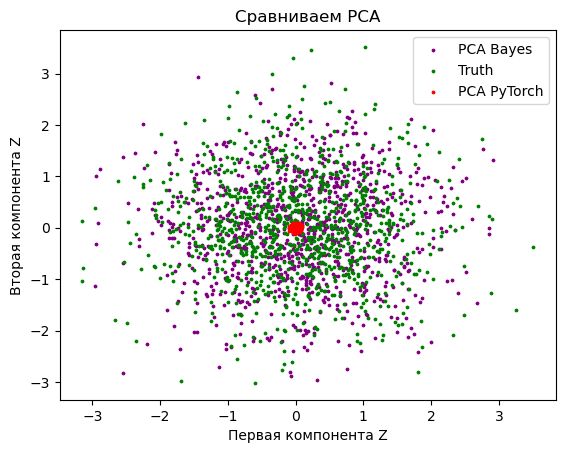

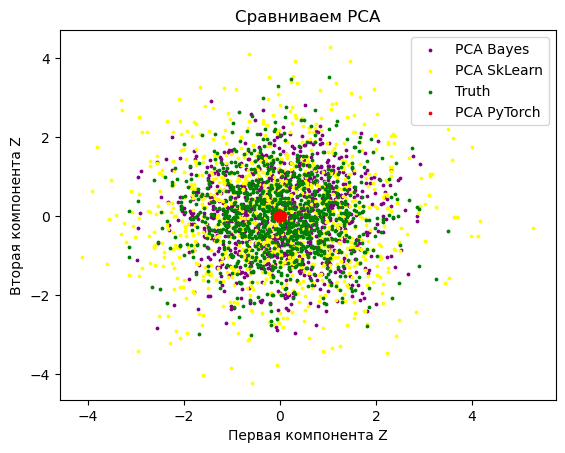

In [176]:
import matplotlib.pyplot as plt
def draw_pca(samples, labels, colors):
    for sam, lab, col in zip(samples, labels, colors):
        plt.scatter(sam[:, 0], sam[:, 1], label=lab, color=col, s=3.0)
    plt.title("Сравниваем PCA")
    plt.xlabel("Первая компонента Z")
    plt.ylabel("Вторая компонента Z")
    plt.legend()
    plt.show()

draw_pca(samples=[z_pca_bayes, Z, z_pca_torch],
         labels=["PCA Bayes", "Truth", "PCA PyTorch"],
         colors=["purple", "green", "red"])
draw_pca(samples=[z_pca_bayes, z_pca_sklearn, Z, z_pca_torch],
         labels=["PCA Bayes", "PCA SkLearn", "Truth", "PCA PyTorch"],
         colors=["purple", "yellow", "green", "red"])

In [206]:
class AdaptiveBayesianPCA:
    def fit(self, X, iters=500):
        self.n_components = X.shape[1]
        self.mu = torch.mean(X, dim=0)
        self.sigma = 1.
        self.alpha = torch.ones(self.n_components)
        self.X = X
        
        ### Init Q
        self.M = torch.randn((X.shape[0], self.n_components))
        self.A_ws = torch.eye(self.n_components)
        self.A = self.sigma*self.A_ws

        self.U = torch.randn((self.n_components, self.n_components))
        self.B_ws = torch.zeros((X.shape[1], self.n_components, self.n_components))
        for k in range(self.B_ws.shape[0]):
            self.B_ws[k] = torch.eye(self.n_components)
        self.B = self.sigma*self.B_ws

        ### Expectation W.TW
        self.__C = torch.diag(torch.sum(torch.diagonal(self.B, dim1=1,dim2=2), dim=1)) + torch.diag(torch.diagonal(self.U.T@self.U))
        ### Expectation ZiZi.T
        self.__D = torch.ones((self.X.shape[0], self.n_components, self.n_components))
        for k in range(self.__D.shape[0]):
            self.__D[k] = self.A + torch.outer(self.M[k], self.M[k])

        for _ in tqdm(range(iters)):
            self.E_step_()
            self.M_step_()

    def E_step_(self):
        self.A_ws = torch.linalg.inv(self.__C + self.sigma*torch.eye(self.n_components))
        self.A = self.sigma*self.A_ws
        for k in range(self.M.shape[0]):
            self.M[k] = self.A_ws@self.U.T@(self.X[k] - self.mu)
            self.__D[k] = self.A + torch.outer(self.M[k], self.M[k])
        
        tmp_B = torch.sum(self.__D, dim=0)
        for k in range(self.B_ws.shape[0]):
            self.B_ws[k] = torch.linalg.inv(tmp_B + self.sigma*torch.diag(self.alpha))
        self.B = self.sigma*self.B_ws
        
        tmp_U_1 = 0
        for k in range(self.X.shape[0]):
            tmp_U_1 += torch.outer(self.X[k] - self.mu, self.M[k])

        tmp_U_2 = torch.linalg.inv(torch.sum(self.__D, dim=0) + self.sigma*torch.diag(self.alpha))
        self.U = tmp_U_1@tmp_U_2
        self.__C = torch.diag(torch.sum(torch.diagonal(self.B, dim1=1,dim2=2), dim=1)) + torch.diag(torch.diagonal(self.U.T@self.U))
    
    def M_step_(self):
        ### Calculate alpha*
        for k in range(self.alpha.shape[0]):
            self.alpha[k] = self.n_components/(torch.sum(torch.diagonal(self.B[k])) + torch.sum(self.U[:,k]**2))
        
        ### Caculate mu*
        self.mu = torch.mean(X, dim=0)

        ### Calculate sigma*
        tmp_S_1 = torch.sum(torch.diagonal(torch.sum(self.__D, dim=0)@self.__C))
        tmp_S_2 = 0
        tmp_S_3 = 0
        
        for k in range(self.X.shape[0]):
            tmp_S_2 += torch.outer(self.mu - self.X[k], self.mu - self.X[k])
            tmp_S_3 += self.M[k]@self.U.T@(self.mu - self.X[k])
        tmp_S_3 = 2*tmp_S_3
        self.sigma = (tmp_S_1+tmp_S_2+tmp_S_3)/(torch.prod(torch.tensor(self.X.shape)))
    
    def get_params(self):
        return self.alpha, self.mu, self.sigma
    
    def transform(self, X):
        A_ws = torch.linalg.inv(self.__C + self.sigma*torch.eye(self.n_components))
        A = self.sigma*A_ws
        Z = []
        for k in range(X.shape[0]):
            mk = self.A_ws@self.U.T@(X[k]-self.mu)
            z = torch
            distribution = MultivariateNormal(loc=mk, covariance_matrix=A)
            Z.append(distribution.rsample(sample_shape=[1]).squeeze(0))
        
        return torch.cat(Z)


In [223]:
pca_adapt_bayes = AdaptiveBayesianPCA()
z_pca_bayes = pca_adapt_bayes.fit(X, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


In [ ]:
alpha, mu, sigma = pca_adapt_bayes.get_params()
print("Alpha = ", alpha)

In [ ]:
Z_adapt_bayes = pca_adapt_bayes.transform(X)
Z_adapt_bayes = torch.stack([Z_adapt_bayes[-3000:-2000], Z_adapt_bayes[-2000:-1000]]).T

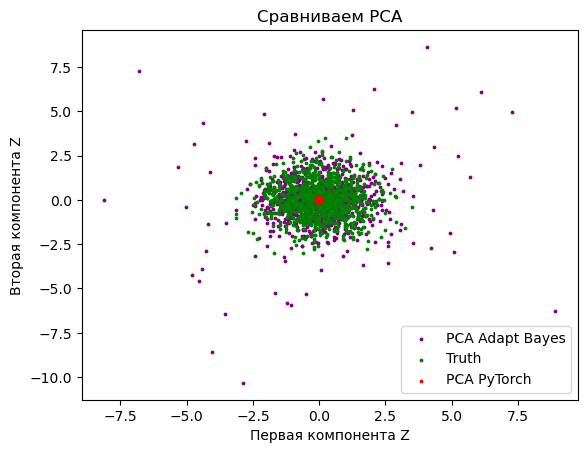

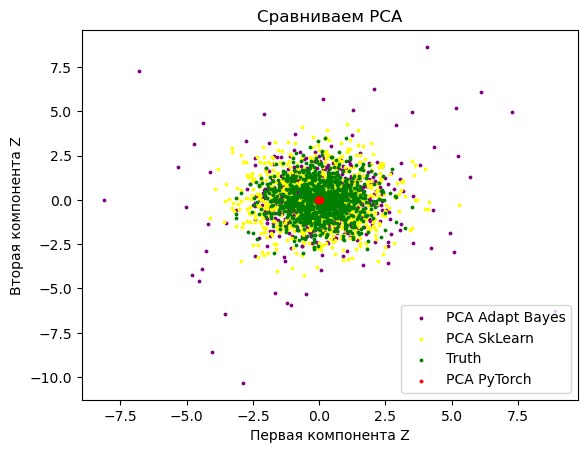

In [200]:
draw_pca(samples=[Z_adapt_bayes, Z, z_pca_torch],
         labels=["PCA Adapt Bayes", "Truth", "PCA PyTorch"],
         colors=["purple", "green", "red"])
draw_pca(samples=[Z_adapt_bayes, z_pca_sklearn, Z, z_pca_torch],
         labels=["PCA Adapt Bayes", "PCA SkLearn", "Truth", "PCA PyTorch"],
         colors=["purple", "yellow", "green", "red"])